/home/keigo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


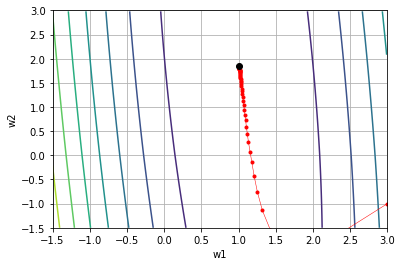

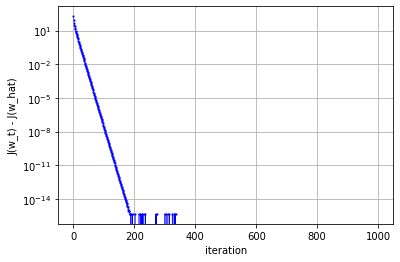

In [64]:
# Adagrad
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv
import itertools

class AdaGrad:
    def __init__(self):
        self.w_1 = np.arange(-1.5,3,0.01)
        self.w_2 = np.arange(-1.5,3,0.02)
        self.W1, self.W2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
        # 評価関数値
        self.Value = np.zeros((len(self.w_1), len(self.w_2)))
        # 重み行列
        self.A = np.array([[250, 15],[15, 4]])
        # 平均
        self.mu = np.array([[1],[2]])
        # 初期値
        self.w_init = np.array([[3], [-1]])
        # 正則化項係数
        self.lamda = 1.0
        # ヘシアン行列の計算の際に単位行列に掛ける係数
        self.delta = 0.02
        
    def calc_eval_fun(self):
        # 評価関数値の計算
        for i in range(len(self.w_1)):
            for j in range(len(self.w_2)):
                w = np.vstack([self.w_1[i], self.w_2[j]])
                self.Value[i, j] = np.dot(np.dot((w - self.mu).T, self.A), w - self.mu) + self.lamda * (np.abs(self.w_1[i]) + np.abs(self.w_2[j]))
                
    def proximal_operation(self, mu, q):
        w_projection = np.zeros(mu.shape)
        for i in range(len(mu)):
            if mu[i] > q:
                w_projection[i] = mu[i] - q
            else:
                if np.abs(mu[i]) < q:
                    w_projection[i] = 0
                else:
                    w_projection[i] = mu[i] + q
        return w_projection
                
    def main(self):
        # cvx
        w_lasso     = cv.Variable((2, 1))
        J           = cv.quad_form(w_lasso - self.mu, self.A) +  self.lamda * cv.norm(w_lasso, 1)
        objective   = cv.Minimize(J)
        constraints = []
        prob        = cv.Problem(objective, constraints)
        result      = prob.solve(solver = cv.CVXOPT) 
        w_lasso     = w_lasso.value

        plt.contour(self.W1, self.W2, self.Value)
        
        wt  = self.w_init
        # r smoothのr
        L   = 1.0 * np.max(np.linalg.eig(2 * self.A)[0])
        # 更新式におけるeta
        eta = 500 / L
        # 値格納用配列
        w_history = []
        self.fvalues   = []
        g_history = []
        
        for t in range(1000):
            w_history.append(wt.T)
            # 勾配
            grad = 2 * np.dot(self.A, wt - self.mu)
            g_history.append(grad.flatten().tolist())
            # ヘシアン行列の計算
            Ht = np.sqrt(np.sum(np.array(g_history) ** 2, axis = 0).T) + self.delta
            Ht = Ht.reshape(2, 1)
            # etaの更新
            eta_t = eta
            # 重みの更新式
            wth    = wt - eta_t * (Ht ** -1 * grad)
            Ht_inv = Ht ** -1
            wt = np.array([self.proximal_operation(wth[0], self.lamda * eta_t * Ht_inv[0]),
                           self.proximal_operation(wth[1], self.lamda * eta_t * Ht_inv[1])])
            # 評価関数値の計算
            J = np.dot(np.dot((wt - self.mu).T, self.A), (wt - self.mu)) + self.lamda * (np.abs(wt[0]) + np.abs(wt[1]))
            self.fvalues.append(J)
        
        self.fvalues   = np.vstack(self.fvalues)
        w_history = np.vstack(w_history)
        
        minfvalue = np.dot(np.dot((w_lasso - self.mu).T, self.A), (w_lasso - self.mu)) + self.lamda * np.sum(np.abs(w_lasso))
        self.minOfMin  = np.min([minfvalue, np.min(self.fvalues)])
        # Drow Graph
        plt.figure(1)
        plt.plot(w_history[:,0], w_history[:,1], 'ro-', markersize=3, linewidth=0.5)
        plt.plot(w_lasso[0], w_lasso[1], 'ko')
        plt.xlim(-1.5, 3)
        plt.ylim(-1.5, 3)
        plt.xlabel("w1")
        plt.ylabel("w2")
        plt.grid()
        
        plt.figure(2)
        plt.semilogy(self.fvalues - self.minOfMin, 'bs-', markersize = 1, linewidth = 0.5)
        plt.xlabel("iteration")
        plt.ylabel("J(w_t) - J(w_hat)")
        plt.grid()
        
AG = AdaGrad()
AG.calc_eval_fun()
AG.main()

/home/keigo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


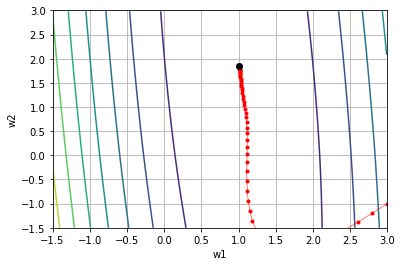

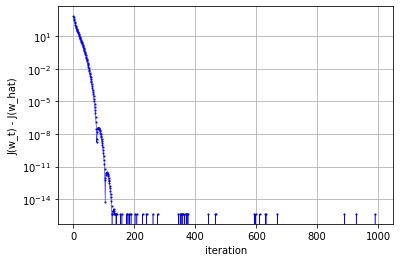

In [65]:
# Adam
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv
import itertools

class Adam:
    def __init__(self):
        self.w_1 = np.arange(-1.5,3,0.01)
        self.w_2 = np.arange(-1.5,3,0.02)
        self.W1, self.W2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
        # 評価関数値
        self.Value = np.zeros((len(self.w_1), len(self.w_2)))
        # 重み行列
        self.A = np.array([[250, 15],[15, 4]])
        # 平均
        self.mu = np.array([[1],[2]])
        # 初期値
        self.w_init = np.array([[3], [-1]])
        # 正則化項係数
        self.lamda = 1.0
        # Adam parameter
        self.beta1 = 0.7
        self.beta2 = 0.99999
        self.epsilon = 1.0e-8
        self.eta = 0.2
        
    def calc_eval_fun(self):
        # 評価関数値の計算
        for i in range(len(self.w_1)):
            for j in range(len(self.w_2)):
                w = np.vstack([self.w_1[i], self.w_2[j]])
                self.Value[i, j] = np.dot(np.dot((w - self.mu).T, self.A), w - self.mu) + self.lamda * (np.abs(self.w_1[i]) + np.abs(self.w_2[j]))

    def proximal_operation(self, mu, q):
        w_projection = np.zeros(mu.shape)
        for i in range(len(mu)):
            if mu[i] > q:
                w_projection[i] = mu[i] - q
            else:
                if np.abs(mu[i]) < q:
                    w_projection[i] = 0
                else:
                    w_projection[i] = mu[i] + q
        return w_projection
    
    def main(self):
        # cvx
        w_lasso     = cv.Variable((2, 1))
        J           = cv.quad_form(w_lasso - self.mu, self.A) +  self.lamda * cv.norm(w_lasso, 1)
        objective   = cv.Minimize(J)
        constraints = []
        prob        = cv.Problem(objective, constraints)
        result      = prob.solve(solver = cv.CVXOPT) 
        w_lasso     = w_lasso.value

        plt.contour(self.W1, self.W2, self.Value)
        
        wt  = self.w_init
        # 値格納用配列
        x_history = []
        self.fvalues   = []
        g_history = []
        mt = np.zeros((2, 1))
        vt = np.zeros((2, 1))
        
        for t in range(1,1001):
            x_history.append(wt.T)
            # 勾配
            grad  = 2 * np.dot(self.A, wt - self.mu)
            mt    = self.beta1 * mt + (1 - self.beta1) * grad
            vt    = self.beta2 * vt + (1 - self.beta2) * (grad * grad)
            mthat = mt / (1 - self.beta1 ** t)
            vthat = vt / (1 - self.beta2 ** t)
            
            g_history.append(grad.T)
            
            stepsize = self.eta * np.ones((2, 1)) / (np.sqrt(vthat) + self.epsilon)
            # 重みの更新式
            wth = wt -  mthat * stepsize
            wt  = np.array([self.proximal_operation(wth[0], self.lamda * stepsize[0]),
                            self.proximal_operation(wth[1], self.lamda * stepsize[1])])
            # 評価関数値の計算
            J = np.dot(np.dot((wt - self.mu).T, self.A), (wt - self.mu)) + self.lamda * (np.abs(wt[0]) + np.abs(wt[1]))
            self.fvalues.append(J)
            
        self.fvalues   = np.vstack(self.fvalues)
        x_history = np.vstack(x_history)
        
        minfvalue = np.dot(np.dot((w_lasso - self.mu).T, self.A), (w_lasso - self.mu)) + self.lamda * np.sum(np.abs(w_lasso))
        self.minOfMin  = np.min([minfvalue, np.min(self.fvalues)])
        # Drow Graph
        plt.figure(1)
        plt.plot(x_history[:,0], x_history[:,1], 'ro-', markersize = 3, linewidth = 0.5)
        plt.plot(w_lasso[0], w_lasso[1], 'ko')
        plt.xlim(-1.5, 3)
        plt.ylim(-1.5, 3)
        plt.xlabel("w1")
        plt.ylabel("w2")
        plt.grid()
        
        plt.figure(2)
        plt.semilogy(self.fvalues - self.minOfMin, 'bs-', markersize = 1, linewidth = 0.5)
        plt.xlabel("iteration")
        plt.ylabel("J(w_t) - J(w_hat)")
        plt.grid()
    
ADAM = Adam()
ADAM.calc_eval_fun()
ADAM.main()

/home/keigo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


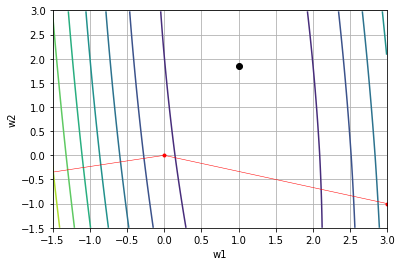

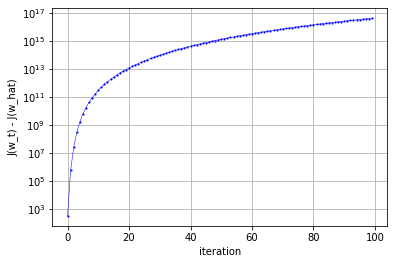

In [66]:
# Adadelta
import math
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv
import itertools

class Adadelta:
    def __init__(self):
        self.w_1 = np.arange(-1.5,3,0.01)
        self.w_2 = np.arange(-1.5,3,0.02)
        self.W1, self.W2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
        # 評価関数値
        self.Value = np.zeros((len(self.w_1), len(self.w_2)))
        # 重み行列
        self.A = np.array([[250, 15],[15, 4]])
        # 平均
        self.mu = np.array([[1],[2]])
        # 初期値
        self.w_init = np.array([[3], [-1]])
        # 正則化項係数
        self.lamda = 1.0
        # Adamdelta parameter
        self.beta = 0.5
        self.epsilon = 1.0e-8
        
    def calc_eval_fun(self):
        # 評価関数値の計算
        for i in range(len(self.w_1)):
            for j in range(len(self.w_2)):
                w = np.vstack([self.w_1[i], self.w_2[j]])
                self.Value[i, j] = np.dot(np.dot((w - self.mu).T, self.A), w - self.mu) + self.lamda * (np.abs(self.w_1[i]) + np.abs(self.w_2[j]))
                
    def proximal_operation(self, mu, q):
        w_projection = np.zeros(mu.shape)
        for i in range(len(mu)):
            if mu[i] > q:
                w_projection[i] = mu[i] - q
            else:
                if np.abs(mu[i]) < q:
                    w_projection[i] = 0
                else:
                    w_projection[i] = mu[i] + q
        return w_projection
                
    def main(self):
        # cvx
        w_lasso     = cv.Variable((2, 1))
        J           = cv.quad_form(w_lasso - self.mu, self.A) +  self.lamda * cv.norm(w_lasso, 1)
        objective   = cv.Minimize(J)
        constraints = []
        prob        = cv.Problem(objective, constraints)
        result      = prob.solve(solver = cv.CVXOPT) 
        w_lasso     = w_lasso.value

        plt.contour(self.W1, self.W2, self.Value)
        
        wt  = self.w_init
        rt  = self.epsilon
        st  = 0.0
        # r smoothのr
        L   = 1.0 * np.max(np.linalg.eig(2 * self.A)[0])
        # 更新式におけるeta
        eta = 500 / L
        # 値格納用配列
        w_history = []
        self.fvalues   = []
        g_history = []
        vt_history = []
        for t in range(100):
            w_history.append(wt.T)
            # 勾配
            grad = 2 * np.dot(self.A, wt - self.mu)
            g_history.append(grad.flatten().tolist())
            # ヘシアン行列の計算
            rt = self.beta * (1 - self.beta) * np.sqrt(np.sum(np.array(g_history) ** 2, axis = 0).T) 
            vt = ((np.sqrt(st) + self.epsilon) / (np.sqrt(rt) + self.epsilon)) * np.sqrt(np.sum(np.array(g_history) ** 2, axis = 0).T) 
            vt = vt.reshape(2, 1)
            st = self.beta * st + (1 - self.beta)
            # etaの更新
            eta_t = eta
            # 重みの更新式
            wth    = wt - vt
            vt_inv = vt ** -1
            wt = np.array([self.proximal_operation(wth[0], self.lamda * eta_t * vt_inv[0]),
                           self.proximal_operation(wth[1], self.lamda * eta_t * vt_inv[1])])
            # 評価関数値の計算
            J = np.dot(np.dot((wt - self.mu).T, self.A), (wt - self.mu)) + self.lamda * (np.abs(wt[0]) + np.abs(wt[1]))
            self.fvalues.append(J)
        
        self.fvalues   = np.vstack(self.fvalues)
        w_history = np.vstack(w_history)
        
        minfvalue = np.dot(np.dot((w_lasso - self.mu).T, self.A), (w_lasso - self.mu)) + self.lamda * np.sum(np.abs(w_lasso))
        self.minOfMin  = np.min([minfvalue, np.min(self.fvalues)])
        # Drow Graph
        plt.figure(1)
        plt.plot(w_history[:,0], w_history[:,1], 'ro-', markersize=3, linewidth=0.5)
        plt.plot(w_lasso[0], w_lasso[1], 'ko')
        plt.xlim(-1.5, 3)
        plt.ylim(-1.5, 3)
        plt.xlabel("w1")
        plt.ylabel("w2")
        plt.grid()
        
        plt.figure(2)
        plt.semilogy(self.fvalues - self.minOfMin, 'bs-', markersize = 1, linewidth = 0.5)
        plt.xlabel("iteration")
        plt.ylabel("J(w_t) - J(w_hat)")
        plt.grid()
        
AD = Adadelta()
AD.calc_eval_fun()
AD.main()

/home/keigo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


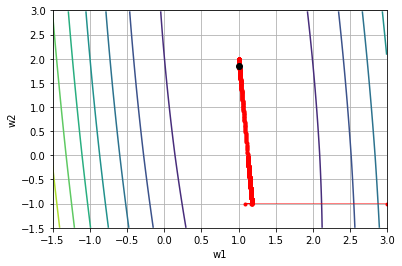

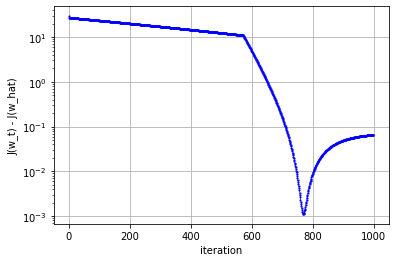

In [67]:
# Momentum
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv
import itertools

class Momentum:
    def __init__(self):
        self.w_1 = np.arange(-1.5,3,0.01)
        self.w_2 = np.arange(-1.5,3,0.02)
        self.W1, self.W2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
        # 評価関数値
        self.Value = np.zeros((len(self.w_1), len(self.w_2)))
        # 重み行列
        self.A = np.array([[250, 15],[15, 4]])
        # 平均
        self.mu = np.array([[1],[2]])
        # 初期値
        self.w_init = np.array([[3], [-1]])
        # 正則化項係数
        self.lamda = 1.0
        # ヘシアン行列の計算の際に単位行列に掛ける係数
        self.delta = 0.02
        
    def calc_eval_fun(self):
        # 評価関数値の計算
        for i in range(len(self.w_1)):
            for j in range(len(self.w_2)):
                w = np.vstack([self.w_1[i], self.w_2[j]])
                self.Value[i, j] = np.dot(np.dot((w - self.mu).T, self.A), w - self.mu) + self.lamda * (np.abs(self.w_1[i]) + np.abs(self.w_2[j]))
                
    def proximal_operation(self, mu, q):
        w_projection = np.zeros(mu.shape)
        for i in range(len(mu)):
            if mu[i] > q:
                w_projection[i] = mu[i] - q
            else:
                if np.abs(mu[i]) < q:
                    w_projection[i] = 0
                else:
                    w_projection[i] = mu[i] + q
        return w_projection
                
    def main(self):
        # cvx
        w_lasso     = cv.Variable((2, 1))
        J           = cv.quad_form(w_lasso - self.mu, self.A) +  self.lamda * cv.norm(w_lasso, 1)
        objective   = cv.Minimize(J)
        constraints = []
        prob        = cv.Problem(objective, constraints)
        result      = prob.solve(solver = cv.CVXOPT) 
        w_lasso     = w_lasso.value

        plt.contour(self.W1, self.W2, self.Value)
        
        wt  = self.w_init
        # r smoothのr
        L   = 1.0 * np.max(np.linalg.eig(2 * self.A)[0])
        # 更新式におけるeta
        eta = 0.001
        v   = 0.0
        gamma = 0.1     # 値格納用配列
        w_history = []
        self.fvalues   = []
        g_history = []
        
        for t in range(1000):
            w_history.append(wt.T)
            # 勾配
            grad = 2 * np.dot(self.A, wt - self.mu)
            v    = gamma * v + grad
            # 重みの更新式
            wth = wt - eta * v
            wt  = np.array([self.proximal_operation(wth[0], eta * grad[0]),
                            self.proximal_operation(wth[1], eta * grad[1])])
        
            # 評価関数値の計算
            J = np.dot(np.dot((wt - self.mu).T, self.A), (wt - self.mu)) + self.lamda * (np.abs(wt[0]) + np.abs(wt[1]))
            self.fvalues.append(J)
        
        self.fvalues   = np.vstack(self.fvalues)
        w_history = np.vstack(w_history)
        
        minfvalue = np.dot(np.dot((w_lasso - self.mu).T, self.A), (w_lasso - self.mu)) + self.lamda * np.sum(np.abs(w_lasso))
        self.minOfMin  = np.min([minfvalue, np.min(self.fvalues)])
        # Drow Graph
        plt.figure(1)
        plt.plot(w_history[:,0], w_history[:,1], 'ro-', markersize=3, linewidth=0.5)
        plt.plot(w_lasso[0], w_lasso[1], 'ko')
        plt.xlim(-1.5, 3)
        plt.ylim(-1.5, 3)
        plt.xlabel("w1")
        plt.ylabel("w2")
        plt.grid()
        
        plt.figure(2)
        plt.semilogy(self.fvalues - self.minOfMin, 'bs-', markersize = 1, linewidth = 0.5)
        plt.xlabel("iteration")
        plt.ylabel("J(w_t) - J(w_hat)")
        plt.grid()
        
MM = Momentum()
MM.calc_eval_fun()
MM.main()

/home/keigo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


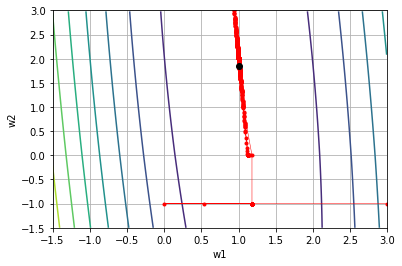

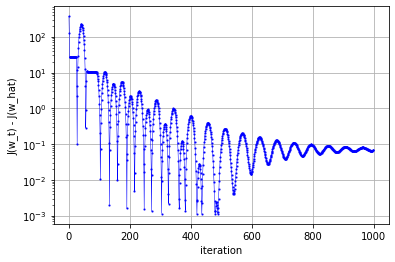

In [68]:
# Nesterov
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv
import itertools

class Nesterov:
    def __init__(self):
        self.w_1 = np.arange(-1.5,3,0.01)
        self.w_2 = np.arange(-1.5,3,0.02)
        self.W1, self.W2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
        # 評価関数値
        self.Value = np.zeros((len(self.w_1), len(self.w_2)))
        # 重み行列
        self.A = np.array([[250, 15],[15, 4]])
        # 平均
        self.mu = np.array([[1],[2]])
        # 初期値
        self.w_init = np.array([[3], [-1]])
        # 正則化項係数
        self.lamda = 1.0
        # ヘシアン行列の計算の際に単位行列に掛ける係数
        self.delta = 0.02
        
    def calc_eval_fun(self):
        # 評価関数値の計算
        for i in range(len(self.w_1)):
            for j in range(len(self.w_2)):
                w = np.vstack([self.w_1[i], self.w_2[j]])
                self.Value[i, j] = np.dot(np.dot((w - self.mu).T, self.A), w - self.mu) + self.lamda * (np.abs(self.w_1[i]) + np.abs(self.w_2[j]))
                
    def proximal_operation(self, mu, q):
        w_projection = np.zeros(mu.shape)
        for i in range(len(mu)):
            if mu[i] > q:
                w_projection[i] = mu[i] - q
            else:
                if np.abs(mu[i]) < q:
                    w_projection[i] = 0
                else:
                    w_projection[i] = mu[i] + q
        return w_projection
                
    def main(self):
        # cvx
        w_lasso     = cv.Variable((2, 1))
        J           = cv.quad_form(w_lasso - self.mu, self.A) +  self.lamda * cv.norm(w_lasso, 1)
        objective   = cv.Minimize(J)
        constraints = []
        prob        = cv.Problem(objective, constraints)
        result      = prob.solve(solver = cv.CVXOPT) 
        w_lasso     = w_lasso.value

        plt.contour(self.W1, self.W2, self.Value)
        
        wt  = self.w_init
        # r smoothのr
        L   = 1.0 * np.max(np.linalg.eig(2 * self.A)[0])
        # 更新式におけるeta
        eta = 0.001
        v   = 0.0
        gamma = 1.0
        w_history = []
        self.fvalues   = []
        g_history = []
        
        for t in range(1000):
            w_history.append(wt.T)
            # 勾配
            grad = 2 * np.dot(self.A, wt - self.mu)
            # 重みの更新式
            v   = gamma * v + grad
            stepsize = gamma * v + grad
            wth = wt - eta * stepsize
            wt  = np.array([self.proximal_operation(wth[0], eta * stepsize[0]),
                            self.proximal_operation(wth[1], eta * stepsize[1])])
            
            # 評価関数値の計算
            J = np.dot(np.dot((wt - self.mu).T, self.A), (wt - self.mu)) + self.lamda * (np.abs(wt[0]) + np.abs(wt[1]))
            self.fvalues.append(J)
        
        self.fvalues   = np.vstack(self.fvalues)
        w_history = np.vstack(w_history)
        
        minfvalue = np.dot(np.dot((w_lasso - self.mu).T, self.A), (w_lasso - self.mu)) + self.lamda * np.sum(np.abs(w_lasso))
        self.minOfMin  = np.min([minfvalue, np.min(self.fvalues)])
        # Drow Graph
        plt.figure(1)
        plt.plot(w_history[:,0], w_history[:,1], 'ro-', markersize=3, linewidth=0.5)
        plt.plot(w_lasso[0], w_lasso[1], 'ko')
        plt.xlim(-1.5, 3)
        plt.ylim(-1.5, 3)
        plt.xlabel("w1")
        plt.ylabel("w2")
        plt.grid()
        
        plt.figure(2)
        plt.semilogy(self.fvalues - self.minOfMin, 'bs-', markersize = 1, linewidth = 0.5)
        plt.xlabel("iteration")
        plt.ylabel("J(w_t) - J(w_hat)")
        plt.grid()
        
Ns = Nesterov()
Ns.calc_eval_fun()
Ns.main()

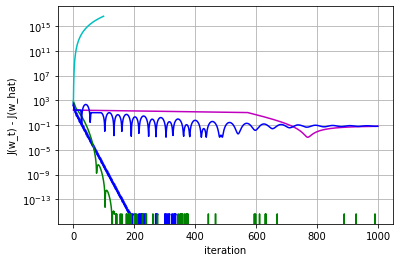

In [70]:
# conpare
# Adagrad
plt.semilogy(AG.fvalues - AG.minOfMin, 'bs-', markersize = 1, linewidth = 1.5)
# Adam
plt.semilogy(ADAM.fvalues - ADAM.minOfMin, 'g-', markersize = 1, linewidth = 1.5)
# Adadelta
plt.semilogy(AD.fvalues - AD.minOfMin, 'c-', markersize = 1, linewidth = 1.5)
# Momentum
plt.semilogy(MM.fvalues - MM.minOfMin, 'm-', markersize = 1, linewidth = 1.5)
# Nesterov
plt.semilogy(Ns.fvalues - Ns.minOfMin, 'b-', markersize = 1, linewidth = 1.5)
plt.xlabel("iteration")
plt.ylabel("J(w_t) - J(w_hat)")
plt.grid()